# Problem Statement

Industry professionals can purchase online courses from X Education, a company that provides education.

At X Education, the lead conversion rate is typically between 30% and 40%. The CEO wants to see an improvement in the lead conversion rate to about 80%.


Create a lead scoring model using a lead dataset with around 9000 data points from the past that includes various criteria like Lead Source, Total Website Time Spent, Total Visits, Last Activity, etc.

In [1]:
#Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, confusion_matrix, roc_auc_score
from scikitplot.metrics import plot_lift_curve

In [2]:
#Import dataset
mql = pd.read_csv('../input/lead-scoring-assignment/Leads.csv')

# Data Preparation

The goal of this part is to impute missing or inaccurate values into the dataset and make sure that all of its characteristics are of the right data type.

In [3]:
#Sample view of the dataset
mql.sample(5)

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
4615,0cd586a1-e1ea-4c91-b98c-fb575af57652,615502,Landing Page Submission,Direct Traffic,No,No,0,2.0,1160,2.0,...,No,Student of SomeSchool,Thane & Outskirts,NaN,NaN,NaN,NaN,No,Yes,Email Opened
7114,ce3f465c-2f03-485e-a323-28c3841ef539,594933,Landing Page Submission,Google,No,No,0,3.0,93,3.0,...,No,Select,Mumbai,NaN,NaN,NaN,NaN,No,No,Modified
6942,ce10e051-fd55-4b65-9d02-009b8378cdf2,596417,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,14.0,15.0,No,No,Modified
7689,f1c84d1a-bdca-43ad-b577-8371041d8ca5,590832,Landing Page Submission,Direct Traffic,No,No,1,2.0,181,2.0,...,No,Potential Lead,Thane & Outskirts,02.Medium,01.High,13.0,19.0,No,Yes,SMS Sent
1413,e186ebc0-250f-4f4e-a766-f328497bca65,645271,Landing Page Submission,Google,No,No,0,4.0,1805,4.0,...,No,NaN,Mumbai,02.Medium,01.High,13.0,18.0,No,No,Email Opened


In [4]:
#Examine current data types and count of non-null entries by feature
mql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
#Count columns with fewer than 9240 observations in mql
cols_w_nulls = [mql[c].isna().max() for c in mql.columns]
sum(cols_w_nulls)

17

Of the 37 features in this dataset, 17 have nulls and several more have incorrect data types.

As part of our data preparation, we review each feature one-by-one to identify correct data types and appropriate null handling.

In [6]:
#Drop Prospect ID, we can use Lead Number as the unique ID for each observation
mql.drop(columns='Prospect ID', axis=1, inplace=True)

Handling Null: Lead Source

* "Lead Source": the place where the lead came from. includes Google, Olark Chat, organic search, etc.

To choose the best approach for null imputation, consider the distribution of the feature.

<function matplotlib.pyplot.show(close=None, block=None)>

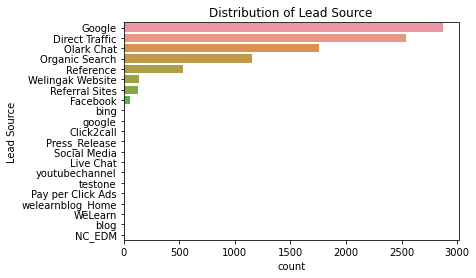

In [7]:
#Plot distribution of Lead Source
sns.countplot(y='Lead Source', data=mql, order = mql['Lead Source'].value_counts().index)
plt.title('Distribution of Lead Source')
plt.show

There isn't a single Lead Source that is the most prevalent that might be used to infer null values. Therefore, the optimal null imputation technique would be to impute nulls with the new value "Unknown".

In [8]:
#Impute nulls with "Unknown"
mql['Lead Source'] = mql['Lead Source'].fillna('Unknown')

#### Data Type Correction: Do Not Email, Do Not Call, Converted

* **Do Not Email**: An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.
* **Do Not Call**: An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.
* **Converted**: The target variable. Indicates whether a lead has been successfully converted or not.


By converting these qualities into boolean values, they will be simpler to use in models, modify, and comprehend.

In [9]:
#Convert Do Not Email, Do Not Call, Converted to boolean values
for c in ['Do Not Email', 'Do Not Call', 'Converted']:
    mql[c] = mql[c].replace('Yes',1)
    mql[c] = mql[c].replace('No',0)
    mql[c] = mql[c].astype(bool)

#### Null Handling: TotalVisits & Page Views Per Visit

* **TotalVisit**: The total number of visits made by the customer on the website.
* **Page Views Per Visit**: The total number of visits made by the customer on the website.

To choose the most effective imputation technique, we evaluate the distribution of each of these features.

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64 



Text(0.5, 1.0, 'Distribution of Total Visits to Website')

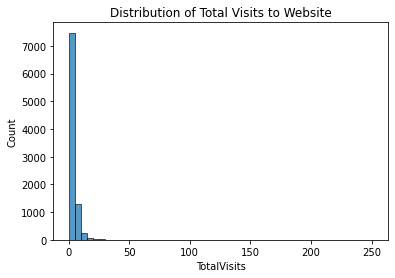

In [10]:
#Examine distribution of Total Visits
print(mql['TotalVisits'].describe(),"\n")

sns.histplot(x='TotalVisits', data=mql, bins=50)
plt.title("Distribution of Total Visits to Website")

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64 



Text(0.5, 1.0, 'Distribution of Page Views Per Visit')

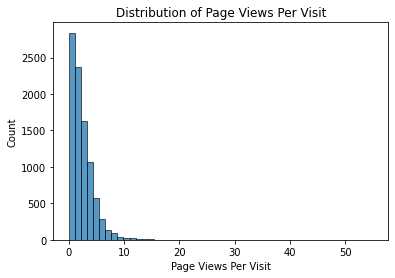

In [11]:
#Examine distribution of Page Views per Visit
print(mql['Page Views Per Visit'].describe(),"\n")

sns.histplot(x='Page Views Per Visit', data=mql, bins=50)
plt.title("Distribution of Page Views Per Visit")

The distributions for both these features is severely left-skewed, suggesting that median imputation would be best suited to handle nulls.

In addition, TotalVisits should be an integer, not a float.

In [12]:
#Impute nulls in both features with median value of the feature
mql['TotalVisits'] = mql['TotalVisits'].fillna(mql['TotalVisits'].median())
mql['Page Views Per Visit'] = mql['Page Views Per Visit'].fillna(mql['Page Views Per Visit'].median())

#Convert data type to int
mql['TotalVisits'] = mql['TotalVisits'].astype('int')

#### Null Handling: Last Activity

* **Last Activity**: Last activity performed by the customer. Includes Email Opened, Olark Chat Conversation, etc.

Assess the distribution of the feature to determine best null imputation method.

Text(0.5, 1.0, 'Distribution of Last Activity')

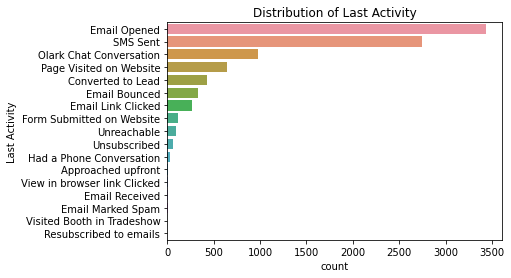

In [13]:
#Plot distribution of leads by Last Activity
sns.countplot(y='Last Activity', data=mql, order = mql['Last Activity'].value_counts().index)
plt.title('Distribution of Last Activity')

No category for Last Activity stands out as the likely value for nulls in this feature. As a result, imputing nulls with a new category called "Null" is best.

In [14]:
#Impute nulls with new category
mql['Last Activity'] = mql['Last Activity'].fillna('Null')

#### Null Handling: Country

* **Country**: The country of the customer.

Assess the distribution of the feature to identify the appropriate null handling method.

Text(0.5, 1.0, 'Distribution of Leads by Country')

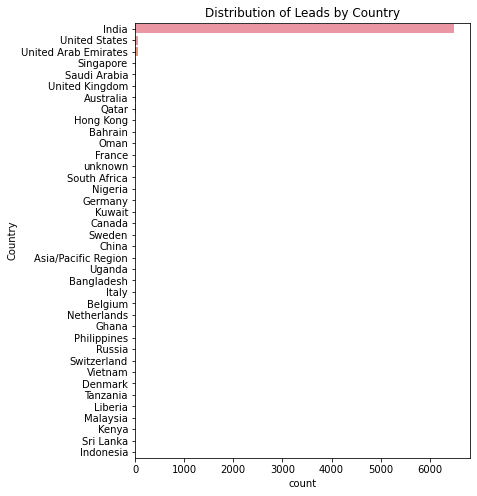

In [15]:
#Plot distribution of Leads by Country
plt.figure(figsize=(6,8))
sns.countplot(y='Country', data=mql, order = mql['Country'].value_counts().index)
plt.title('Distribution of Leads by Country')

In [16]:
#Print the percentage of values that are null in the Country feature
print(round(mql['Country'].isna().sum()*100/len(mql['Country']),2),'% of values in Country are null.')

26.63 % of values in Country are null.


Maybe we can deduce the country a lead is located in from the city they have indicated they are located in.

Text(0.5, 1.0, 'Distribution of Leads by City where Country is null')

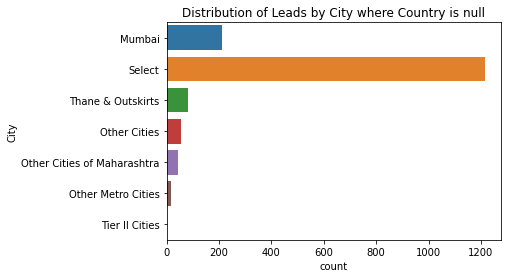

In [17]:
#Plot distribution of City where Country is null
sns.countplot(y='City', data=mql[mql['Country'].isna()], order = mql['City'].value_counts().index)
plt.title('Distribution of Leads by City where Country is null')

For cities that are located in India, we can impute null values in Country as "India". Otherwise, we should impute nulls in Country as "Unknown"

In [18]:
#Impute nulls in Country based on Country
india_cities = ['Mumbai','Other Cities of Maharashtra','Thane & Outskirts']

for i in mql[mql['Country'].isnull()].index:
    if mql.loc[i,'City'] in india_cities:
        mql.loc[i,'Country'] = 'India'
    else:
        mql.loc[i,'Country'] = 'Unknown'

#### Data Type Correction: Search, Magazine, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement

* **Search**: Indicating whether the customer had seen the ad in any of the listed items (i.e. during a web search).
* **Magazine**: Indicating whether the customer had seen the ad in any of the listed items (i.e. in a magazine).
* **Newspaper Article**: Indicating whether the customer had seen the ad in any of the listed items (i.e. in a newspaper article).
* **X Education Forums**: Indicating whether the customer had seen the ad in any of the listed items (i.e. in a X Education forum).
* **Newspaper**: Indicating whether the customer had seen the ad in any of the listed items (i.e. in a newspaper).
* **Digital Advertisement**: Indicating whether the customer had seen the ad in any of the listed items (i.e. in a digital ad).

These features will be easier to manipulate, interpret, and use in a model by converting them to boolean values.

In [19]:
#Convert yes/no field to boolean
for c in ['Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement']:
    mql[c] = mql[c].replace('Yes',1)
    mql[c] = mql[c].replace('No',0)
    mql[c] = mql[c].astype(bool)

#### Data Type Correction: Through Recommendations, Receive More Updates About Our Courses

* **Through Recommendations**: Indicates whether the customer came in through recommendations.
* **Receive More Updates About Our Courses**: Indicates whether the customer chose to receive more updates about the courses.

These features will be easier to manipulate, interpret, and use in a model by converting them to boolean values.

In [20]:
#Convert yes/no field to boolean
for c in ['Through Recommendations', 'Receive More Updates About Our Courses']:
    mql[c] = mql[c].replace('Yes',1)
    mql[c] = mql[c].replace('No',0)
    mql[c] = mql[c].astype(bool)

#### Null Handling: Specialization, How did you hear about X Education

* **Specialization**: The industry domain in which the customer worked before. Includes the level 'Select Specialization' which means the customer had not selected this option while filling the form.
* **How did you hear about X Education**: The source from which the customer heard about X Education.
* **What is your current occupation**: Indicates whether the customer is a student, umemployed or employed.
* **What matters most to you in choosing a course**: An option selected by the customer indicating what is their main motto behind doing this course.

Assess the distribution of these features to determine best null imputation method.

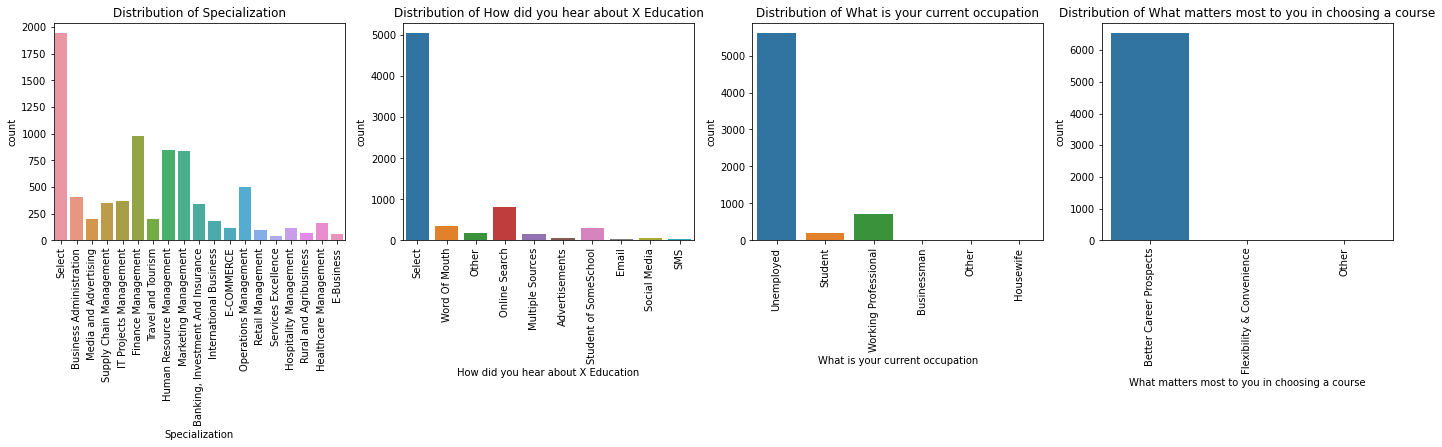

In [21]:
#Examine distribution dropdown fields
dropdown_fields = ['Specialization','How did you hear about X Education','What is your current occupation','What matters most to you in choosing a course']

fig, axes = plt.subplots(nrows=1, ncols=len(dropdown_fields), figsize=(24, 4))

for i in range(len(dropdown_fields)):
    sns.countplot(x=dropdown_fields[i], data=mql, ax=axes[i])
    plt.sca(axes[i])
    plt.title("Distribution of " + dropdown_fields[i])
    plt.xticks(rotation=90)

There seems to be a lot of "Select" values, which are equal to nulls. These values can be swapped out for nulls.

We can impute nulls as "Unknown" since there isn't a single value for either of these qualities with which nulls can be associated. We may also determine the proportion of null values in each feature.


In [22]:
#Impute "Select" with null & print percentage of values in each feature with nulls
for c in dropdown_fields:
    mql[c].replace('Select',np.NaN, inplace=True)
    print(round(mql[c].isna().sum()*100/len(mql[c]),2),'% of values in',c,'are null.')

36.58 % of values in Specialization are null.
78.46 % of values in How did you hear about X Education are null.
29.11 % of values in What is your current occupation are null.
29.32 % of values in What matters most to you in choosing a course are null.


In [23]:
#Impure nulls with "Unknown"
for c in dropdown_fields:
    mql[c].fillna('Unknown', inplace=True)

#### Data Type Correction: Update me on Supply Chain Content, Get updates on DM Content

* **Update me on Supply Chain Content**: Indicates whether the customer wants updates on the Supply Chain Content.
* **Get updates on DM Content**: Indicates whether the customer wants updates on the DM Content.

These features will be easier to manipulate, interpret, and use in a model by converting them to boolean values.

In [24]:
#Convert yes/no field to boolean
for c in ['Update me on Supply Chain Content', 'Get updates on DM Content']:
    mql[c] = mql[c].replace('Yes',1)
    mql[c] = mql[c].replace('No',0)
    mql[c] = mql[c].astype(bool)

#### Drop Feature: Tags

* **Tags**: Tags assigned to customers indicating the current status of the lead.

Since Tags is determined by the progress of a lead through the marketing funnel, is it likely endogenous to the conversion status of the lead. As a result, this feature should be dropped.

In [25]:
#Drop Tags feature
mql.drop(columns='Tags', axis=1, inplace=True)

#### Drop Feature: Lead Quality

* **Lead Quality**: Indicates the quality of lead based on the data and intuition the employee who has been assigned to the lead.

Since Lead Quality is the measure we are looking to replace with the Lead Score, we should not include in our model.

In [26]:
#Drop Lead Quality feature
mql.drop(columns='Lead Quality', axis=1, inplace=True)

#### Null Handling: Lead Profile

* **Lead Profile**: A lead level assigned to each customer based on their profile.

Assess the distribution of this feature to determine best null imputation method.

Text(0.5, 1.0, 'Distribution of Leads by Lead Profile')

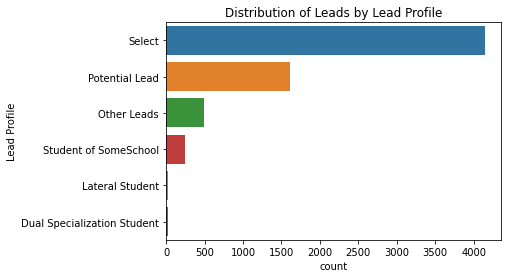

In [27]:
#Plot distribution of Lead Profile
sns.countplot(y='Lead Profile', data=mql, order = mql['Lead Profile'].value_counts().index)
plt.title('Distribution of Leads by Lead Profile')

A large portion of values are "Select", which is equivalent to a null. There is no single lead profile that stands out as a clear value for null imputation. As a result, nulls should be imputed with the value "Unknown".

In [28]:
#Impute "Select" value with null
mql['Lead Profile'].replace('Select', np.NaN, inplace=True)

In [29]:
#Impute nulls with "Unknown"
mql['Lead Profile'].fillna('Unknown', inplace=True)

#### Null Handling: City

* **City**: The city of the customer.

Assess the distribution of the feature to determine best null imputation method.

Text(0.5, 1.0, 'Distribution of City')

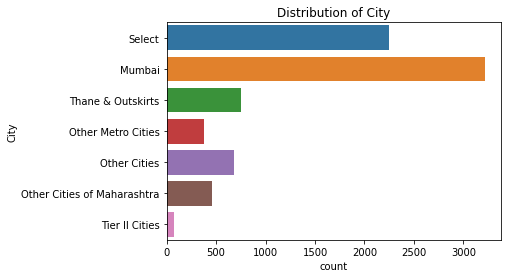

In [30]:
#Examine distribution of City
sns.countplot(y='City', data=mql)
plt.title('Distribution of City')

Again, "Select" is used a lot as values, which is the same as a null. No particular city stands out as a definite value for null imputation. Therefore, the value "Unknown" should be imputed to nulls.


In [31]:
#Impute "Select" value with null
mql['City'].replace('Select', np.NaN, inplace=True)

In [32]:
#Impute nulls with "Unknown"
mql['City'].fillna('Unknown', inplace=True)

#### Correction of Data Type: I consent to paying the money via cheque, Mastering The Interview is available without cost.

* If the consumer has accepted to pay the amount by cheque or not, it is indicated by the phrase "I agree to pay the amount by cheque."
* Whether the consumer wants a free copy of "Mastering the Interview" is indicated by the phrase "A free copy of Mastering The Interview."


By converting these qualities into boolean values, they will be simpler to use in models, modify, and comprehend.

In [33]:
#Convert remaining yes/no fields to boolean values
for c in ['I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']:
    mql[c] = mql[c].replace('Yes',1)
    mql[c] = mql[c].replace('No',0)
    mql[c] = mql[c].astype(bool)

#### Data Type Correction: Object to Category

Categorical variables with be more easily interpreted by our model if they recorded as such.

In [34]:
#Convert string type fields to category type
for c in mql.columns:
    if mql[c].dtype=='object': mql[c] = mql[c].astype('category')

Finally, we can review the dataset to ensure no features contain nulls and all features are of the correct data type.

#### Asymmetrique Index & Scores

* **Asymmetrique Activity Index**: An index and score assigned to each customer based on their activity and their profile.
* **Asymmetrique Profile Index**: An index and score assigned to each customer based on their activity and their profile.
* **Asymmetrique Activity Score**: An index and score assigned to each customer based on their activity and their profile.
* **Asymmetrique Profile Score**: An index and score assigned to each customer based on their activity and their profile.

Assess the distribution of each feature to determine the most appropriate null imputation method.

In [35]:
#Print descriptive statistics of score features
stats_AS = pd.DataFrame(
    {'Asymmetrique Activity Score':mql['Asymmetrique Activity Score'].describe(),
    'Asymmetrique Profile Score':mql['Asymmetrique Profile Score'].describe()})
stats_AS

,Asymmetrique Activity Score,Asymmetrique Profile Score
count,5022.000000,5022.000000
mean,14.306252,16.344883
std,1.386694,1.811395
min,7.000000,11.000000
25%,14.000000,15.000000
50%,14.000000,16.000000
75%,15.000000,18.000000
max,18.000000,20.000000


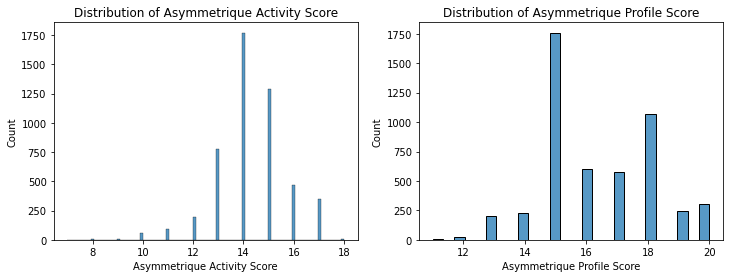

In [36]:
#Plot distribution of Asymmetrique Activity Score & Asymmetrique Profile Score
score_fields = ['Asymmetrique Activity Score','Asymmetrique Profile Score']

fig, axes = plt.subplots(nrows=1, ncols=len(score_fields), figsize=(12, 4))

for i in range(len(score_fields)):
    sns.histplot(x=score_fields[i], data=mql, ax=axes[i])       
    plt.sca(axes[i])
    plt.title("Distribution of " + score_fields[i])

Both distributions are slight left-skewed. As a result, median imputation may be more appropriate than mean imputation.

In [37]:
#Impute nulls with median
for f in score_fields:
    mql[f].fillna(mql[f].median(), inplace=True)

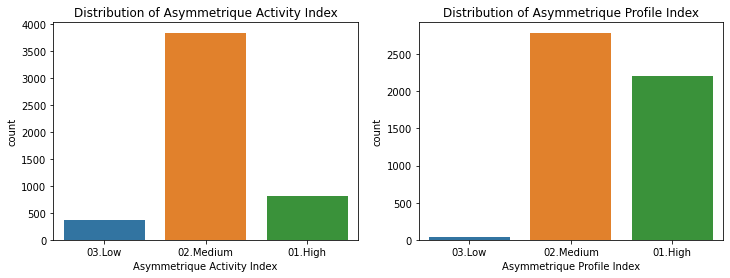

In [38]:
#Plot distribution of Asymmetrique Activity Index & Asymmetrique Profile Index
index_fields = ['Asymmetrique Activity Index','Asymmetrique Profile Index']

fig, axes = plt.subplots(nrows=1, ncols=len(index_fields), figsize=(12, 4))

for i in range(len(index_fields)):
    sns.countplot(x=index_fields[i], data=mql, ax=axes[i], order=['03.Low','02.Medium','01.High'])       
    plt.sca(axes[i])
    plt.title("Distribution of " + index_fields[i])

Both of these index features appear to be redundant if the index features are simply grouped based on the asymmetrique score. By looking at the average Asymetrique Score by Asymetrique Index, we can verify this.

In [39]:
#Group by Asymmetrique Activity Index
grouped_by_activity_index = mql.groupby('Asymmetrique Activity Index').agg({'Asymmetrique Activity Score':'mean'})
grouped_by_activity_index

,Asymmetrique Activity Score
Asymmetrique Activity Index,
01.High,16.437272
02.Medium,14.134931
03.Low,11.290055


In [40]:
#Group by Asymmetrique Profile Index
grouped_by_profile_index = mql.groupby('Asymmetrique Profile Index').agg({'Asymmetrique Profile Score':'mean'})
grouped_by_profile_index

,Asymmetrique Profile Score
Asymmetrique Profile Index,
01.High,18.128007
02.Medium,14.987446
03.Low,11.709677


As can be seen above, Asymmetrique Activity/Profile Index values appear to simply bucket Asymmetrique Activity/Profile Scores. As a result, the index features are redundant and can be dropped.

In [41]:
#Drop Asymmetrique Index columns
mql.drop(columns=['Asymmetrique Activity Index','Asymmetrique Profile Index'], axis=1, inplace=True)

We can now review the remaining features in the dataset to ensure none of any nulls and that all data types are correct.

In [42]:
#Review dataset
mql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Number                                    9240 non-null   int64   
 1   Lead Origin                                    9240 non-null   category
 2   Lead Source                                    9240 non-null   category
 3   Do Not Email                                   9240 non-null   bool    
 4   Do Not Call                                    9240 non-null   bool    
 5   Converted                                      9240 non-null   bool    
 6   TotalVisits                                    9240 non-null   int64   
 7   Total Time Spent on Website                    9240 non-null   int64   
 8   Page Views Per Visit                           9240 non-null   float64 
 9   Last Activity                            

# Exploratory Data Analysis

This section seeks to explore the relationship between each feature of the dataset and the target variable, Converted.

To facilitate this process, we define two functions that allow rapid comparison of distribution by Converted.

In [43]:
#Create functions to facilitate EDA

def count_by_converted(feature, target='Converted'):
    #Plot a seaborn countplot for the feature by Converted & add a relevant title
    sns.countplot(y=feature, data=mql, hue=target, order = mql[feature].value_counts().index)
    plt.title("Distribution of " + feature + " by Converted")
    plt.show
    
def confusionmatrix_by_converted(feature, target='Converted'):
    #Plot confusion matrix heatmap of a boolean feature vs. Converted & add relevant labels
    cm=confusion_matrix(mql[feature], mql[target])
    sns.heatmap(cm, annot=True, fmt='', xticklabels=['No','Yes'], yticklabels=['No','Yes'], cmap='Purples')
    plt.title(feature + " vs. " + target + " Confusion Matrix")
    plt.xlabel(target)
    plt.ylabel(feature)
    plt.show()

#### Univariate Analysis - Converted

In [44]:
#Calculate the conversion rate of leads across the dataset
round(mql['Converted'].mean()*100,2)

38.54

The average lead conversion rate across this dataset is 38.54%.

#### Univariate Analysis - Lead Origin

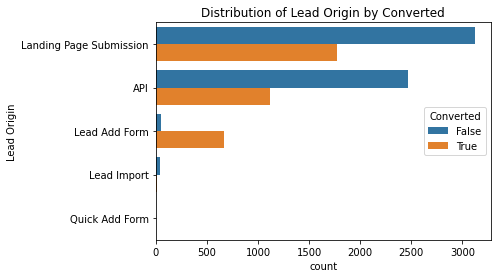

In [45]:
#Plot distribution of Lead Origin by Converted
count_by_converted('Lead Origin')

**Observations**
* Significantly more leads convert when they originate from the "Lead Add Form".
* The lead conversion rate appears slighly higher among leads originating from "Landing Page Submission" than from "API".

#### Univariate Analysis - Lead Source

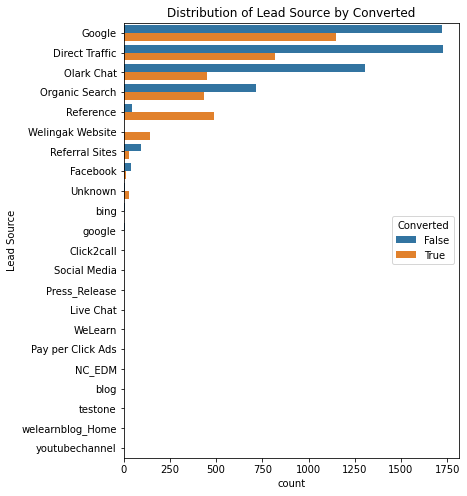

In [46]:
#Plot distribution of Lead Source by Converted
plt.figure(figsize=(6, 8))
count_by_converted('Lead Source')

**Observations**
 * **It is feasible that raising the proportion of leads that are referred and that come from the Willingak Website might raise the overall conversion rate.** Conversion rate looks to be highest for leads that come from the Wellingak Website or that are recommended.

* Although the amount of leads from Google and Direct Traffic is comparable, the conversion rate for leads from Google looks to be greater. Organic Search generates less leads than Google, but the conversion rates of leads from both of these sources tend to be comparable.

#### Univariate Analysis - Do Not Call

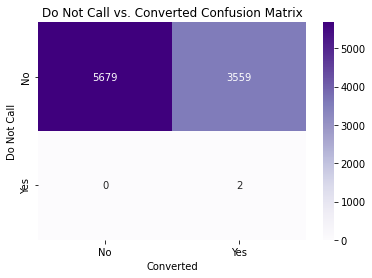

In [47]:
#Plot confusion matrix of Do Not Call against Converted
confusionmatrix_by_converted('Do Not Call')

**Observations**
* The vast majority of leads indicate "No" under Do Not Call, suggesting that the sales team is free to contact them by phone.
* The conversion rate among leads that indicate "No" under Do Not Call is 38.52%.
* While very few leads have a "Yes" under Do Not Call, the conversion rate among these appears to be 100%.

#### Univariate Analysis - Do Not Email

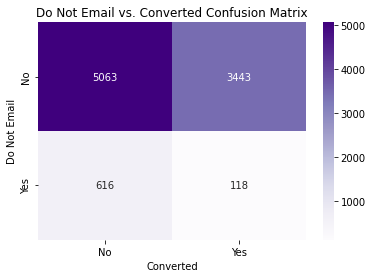

In [48]:
#Plot confusion matrix of Do Not Email against Converted
confusionmatrix_by_converted('Do Not Email')

**Observations**
* Again, the overwhelming majority of leads select "No" under Do Not Email, indicating that the sales staff may email them at any time. Leads who select "No" under Do Not Call have a conversion rate of 40.47%.

* Only 7.94% of leads have the option to "Yes" under Do Not Call. 16.07% of them are expected to convert, which is more than half the conversion rate of leads that are email-opening leads.

#### Univariate Analysis - TotalVisits

In [49]:
#Get descriptive statistics on TotalVisits by Converted
stats_TV = pd.DataFrame(
    {'TotalVisits_Overall':mql['TotalVisits'].describe(),
    'TotalVisits_Converted':mql[mql['Converted']==True]['TotalVisits'].describe(),
    'TotalVisits_NotConverted':mql[mql['Converted']==False]['TotalVisits'].describe()})
stats_TV

,TotalVisits_Overall,TotalVisits_Converted,TotalVisits_NotConverted
count,9240.000000,3561.000000,5679.000000
mean,3.438636,3.615838,3.327522
std,4.819024,5.486307,4.345521
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,3.000000,3.000000,3.000000
75%,5.000000,5.000000,4.000000
max,251.000000,251.000000,141.000000


**Observations**
* On average, leads that convert appear to visit the website slightly more than leads that do not convert

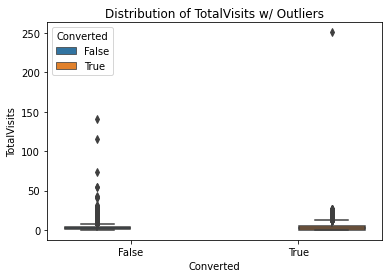

In [50]:
#Plot boxplots for distribution of TotalVisits by Converted
sns.boxplot(y='TotalVisits', data=mql, x='Converted', hue='Converted')
plt.title("Distribution of TotalVisits w/ Outliers")
plt.show()

Given the prevalence of outliers, it is difficult to visualise this distribution. We may create the same plot by excluding leads with TotalVisits > 50 in order to more clearly see the distribution of Total visits.

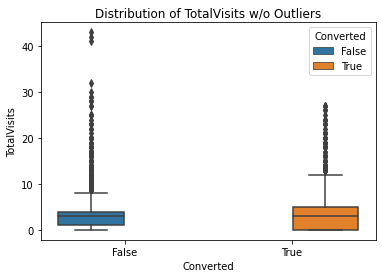

In [51]:
#Remove outliers (TotalVisits > 50) and plot boxplots for distribution of TotalVisits by Converted
sns.boxplot(y='TotalVisits', data=mql[mql['TotalVisits']<=50], x='Converted', hue='Converted')
plt.title("Distribution of TotalVisits w/o Outliers")
plt.show()

**Observations**
* In addition to visiting the website more often, leads that convert appear to show a higher spread and IQR than leads that do not convert.

#### Univariate Analysis - Total Time Spent on Website

In [52]:
#Get descriptive statistics on Total Time Spent on Website by Converted
stats_TT = pd.DataFrame(
    {'TotalTime_Overall':mql['Total Time Spent on Website'].describe(),
    'TotalTime_Converted':mql[mql['Converted']==True]['Total Time Spent on Website'].describe(),
    'TotalTime_NotConverted':mql[mql['Converted']==False]['Total Time Spent on Website'].describe()})
stats_TT

,TotalTime_Overall,TotalTime_Converted,TotalTime_NotConverted
count,9240.000000,3561.000000,5679.000000
mean,487.698268,738.546757,330.404473
std,548.021466,615.656010,432.231915
min,0.000000,0.000000,0.000000
25%,12.000000,0.000000,16.000000
50%,248.000000,832.000000,179.000000
75%,936.000000,1268.000000,393.000000
max,2272.000000,2253.000000,2272.000000


**Observations**
* On average, leads that convert appear to spent more than double the time that leads that do not convert on the website.

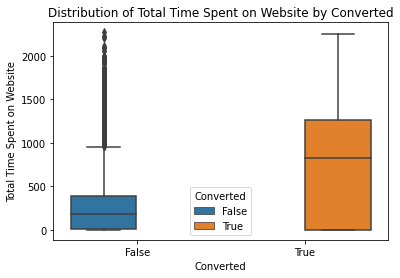

In [53]:
#Plot boxplots for distribution of Total Time Spent on Website by Converted
sns.boxplot(y='Total Time Spent on Website', data=mql, x='Converted', hue='Converted')
plt.title("Distribution of Total Time Spent on Website by Converted")
plt.show()

**Observations**
* The IQR of Total Time Spent on Website for leads that convert is much higher than for leads that do not convert.
* **It is possible that driving leads to spend more time on the website would increase the overall conversion rate.**

#### Univariate Analysis - Page Views Per Visit

In [54]:
#Get descriptive statistics for Page Views Per Visit by Converted
stats_PV = pd.DataFrame(
    {'TotalTime_Overall':mql['Page Views Per Visit'].describe(),
    'TotalTime_Converted':mql[mql['Converted']==True]['Page Views Per Visit'].describe(),
    'TotalTime_NotConverted':mql[mql['Converted']==False]['Page Views Per Visit'].describe()})
stats_PV

,TotalTime_Overall,TotalTime_Converted,TotalTime_NotConverted
count,9240.000000,3561.000000,5679.000000
mean,2.357440,2.343707,2.366052
std,2.145781,2.109825,2.168163
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,3.000000,3.330000,3.000000
max,55.000000,24.000000,55.000000


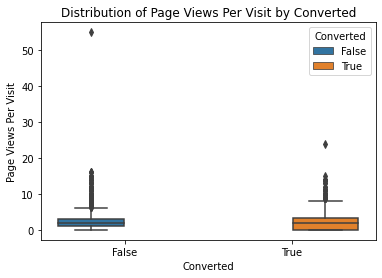

In [55]:
#Plot boxplots for distribution of Page Views Per Visit by Converted
sns.boxplot(y='Page Views Per Visit', data=mql, x='Converted', hue='Converted')
plt.title("Distribution of Page Views Per Visit by Converted")
plt.show()

**Observations** 
* Regardless of conversion status, all leads appear to view a comparable amount of pages every visit on average. The IQR of Page Views each Visit for leads that convert, however, is higher in part because many of these leads have an average of 0 page views each visit. The outlier who, on average, visited 55 pages per visit might not be a lead at all but rather a competitor or a member of staff who is browsing the website.

#### Univariate Analysis - Last Activity

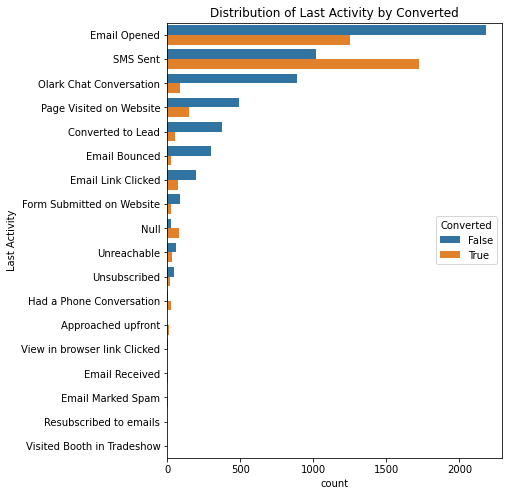

In [56]:
#Plot distribution of Last Activity by Converted
plt.figure(figsize=(6,8))
count_by_converted('Last Activity')

**Observations** 
* SMS Sent is by far the last activity with the highest conversion rate; further research is necessary to ascertain if this is due to the activity's effectiveness or merely the stage in the lead nurturing process at which it occurs.


#### Univariate Analysis - Search

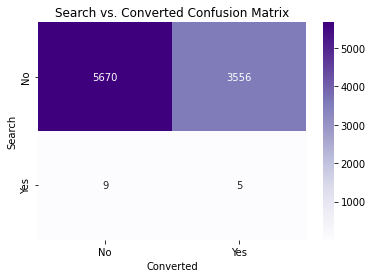

In [57]:
#Plot distribution of Search by Converted
confusionmatrix_by_converted('Search')

**Observations**
* Very few leads have seen an ad during a web search

#### Univariate Analysis - Magazine

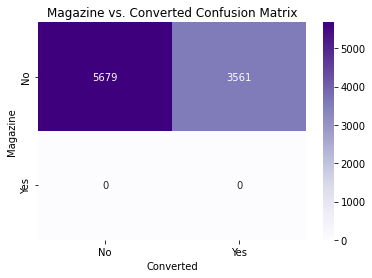

In [58]:
#Plot distribution of Magazine by Converted
confusionmatrix_by_converted('Magazine')

**Observations**
* No leads saw an ad in a magazine.
* **X Education may want to reconsider investing in this marketing channel.**

#### Univariate Analysis - Newspaper Article

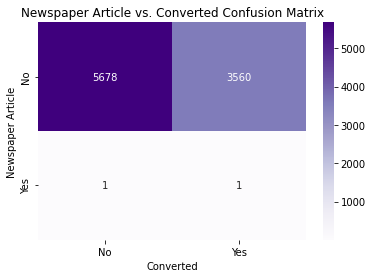

In [59]:
#Plot distribution of Newspaper Article by Converted
confusionmatrix_by_converted('Newspaper Article')

**Observations**
* Very few leads saw an ad in a newspaper article.
* **X Education may want to reconsider investing in this marketing channel as well.**

#### Univariate Analysis - X Education Forums

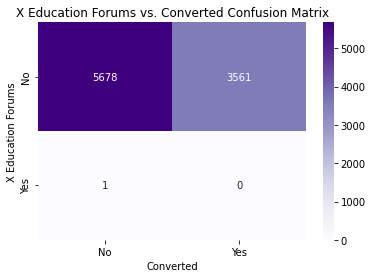

In [60]:
#Plot distribution of X Education Forums by Converted
confusionmatrix_by_converted('X Education Forums')

**Observations**
* Very few leads saw an ad in an X Education Forum.

#### Univariate Analysis - Newspaper

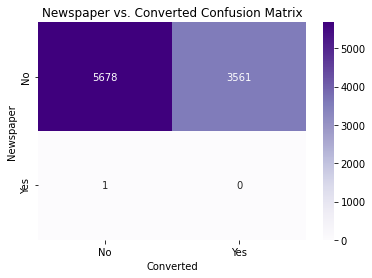

In [61]:
#Plot distribution of Newspaper by Converted
confusionmatrix_by_converted('Newspaper')

**Observations**
* Very few leads saw an ad in a newspaper.
* **X Education may want to reconsider investing in this marketing channel as well.**

#### Univariate Analysis - Digital Advertisement

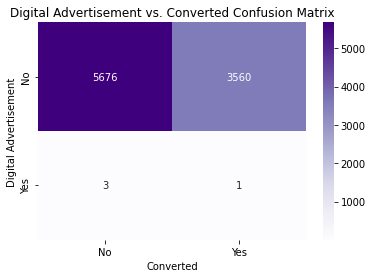

In [62]:
#Plot distribution of Digital Advertisement by Converted
confusionmatrix_by_converted('Digital Advertisement')

**Observations**
* Very few leads saw an ad in a Digital Advertisement.

#### Univariate Analysis - Through Recommendations

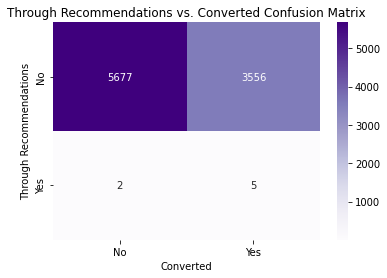

In [63]:
#Plot distribution of Through Recommendations by Converted
confusionmatrix_by_converted('Through Recommendations')

**Observations** * 
There aren't many leads that seem to have come from recommendations. This is odd because "Reference" is listed as a Lead Source on more than 500 leads. Are referral and recommendation distinct terms? In what way, if so?

#### Univariate Analysis - Receive More Updates About Our Courses

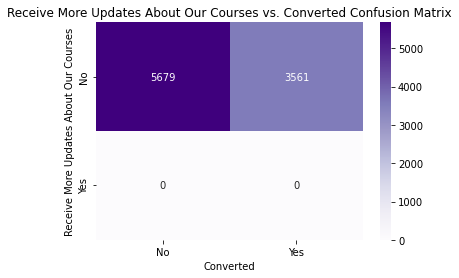

In [64]:
#Plot distribution of Receive More Updates About Our Courses by Converted
confusionmatrix_by_converted('Receive More Updates About Our Courses')

**Observations**
* Not a single lead indicated that they wanted to receive more updates on X Education courses. 
* If this is not a data error, it should be a point of concern for the organization.

#### Univariate Analysis - Update me on Supply Chain Content

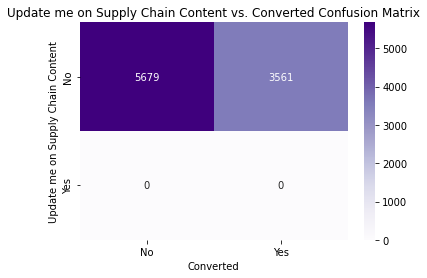

In [65]:
#Plot distribution of Update me on Supply Chain Content by Converted
confusionmatrix_by_converted('Update me on Supply Chain Content')

**Observations**
* Not a single lead indicated that they wanted to receive updates on supply chain content.
* Sending out this kind of content to leads is evidently not of interest to them.

#### Univariate Analysis - Get updates on DM Content

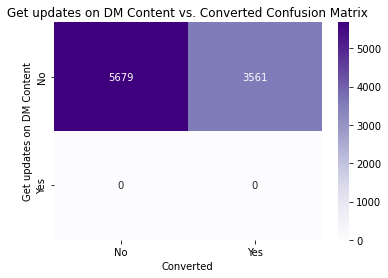

In [66]:
#Plot distribution of Get updates on DM Content by Converted
confusionmatrix_by_converted('Get updates on DM Content')

**Observations**
* Not a single lead indicated that they wanted to receive updates on DM content.
* Sending out this kind of content to leads is evidently not of interest to them.

#### Univariate Analysis - I agree to pay the amount through cheque

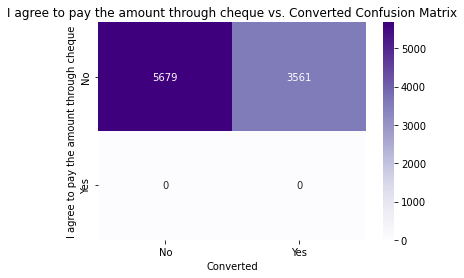

In [67]:
#Plot distribution of I agree to pay the amount through cheque by Converted
confusionmatrix_by_converted('I agree to pay the amount through cheque')

**Observations**
* Not a single lead indicated that they wanted to pay by cheque.
* This payment method is evidently not of interest to leads.

#### Univariate Analysis - A free copy of Mastering The Interview

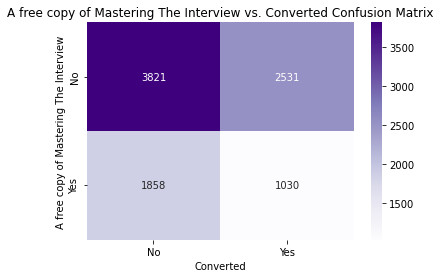

In [68]:
#Plot distribution of A free copy of Mastering The Interview by Converted
confusionmatrix_by_converted('A free copy of Mastering The Interview')

In [69]:
#Compute conversion rate among leads who did and didn't want to receive a free copy of Mastering The Interview
print('The overall lead conversion rate is ', mql['Converted'].mean())
print('The lead conversion rate among those who received a free copy of Mastering The Interview is ',mql[mql['A free copy of Mastering The Interview']==True]['Converted'].mean())
print('The lead conversion rate among those who DID NOT receive a free copy of Mastering The Interview is ',mql[mql['A free copy of Mastering The Interview']==False]['Converted'].mean())

The overall lead conversion rate is  0.3853896103896104
The lead conversion rate among those who received a free copy of Mastering The Interview is  0.35664819944598336
The lead conversion rate among those who DID NOT receive a free copy of Mastering The Interview is  0.3984571788413098


**Observations**
* Nearly 1/3 leads wanted to receive a free copy of Mastering The Interview
* Interestingly, leads who received a free copy of Mastering The Interview had a lower conversion rate!
* **Could this be because once leads receive a copy for Mastering The Interview, they don't feel the need for X Education's courses?**

#### Univariate Analysis - Last Notable Activity

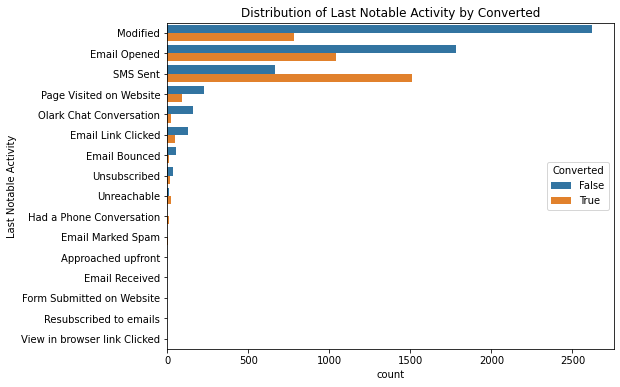

In [70]:
#Plot distribution of Last Notable Activity by Converted
plt.figure(figsize=(8,6))
count_by_converted('Last Notable Activity')

**Observations**

* As seen under Last Activity, SMS Sent is the Last Notable Activity with the highest conversion rate.

# Model Development

#### Data Division


We identify the target variable and all other dataset attributes, excluding Lead Number. Coding of categorical variables via One-Hot Encoding.

Then, we divide our data into a training set and a testing set, using 70% of the data for the training set and 30% for the test set, respectively. 


In [71]:
#Split data into training and testing set
drop_cols = ['Lead Number','Converted']
X = pd.get_dummies(mql.drop(columns=drop_cols, axis=1))
y = mql['Converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

#### Feature Scaling

Most classification models perform better after feature scaling. This is because numeric predictors often have different centers and ranges. For this dataset, numeric predictors include the following:

* TotalVisits
* Total Time Spent on Website
* Page Views per Visit

Since none of these features follow a normal distribution, standardization using MinMaxScaler is the prefered feature scaling method.

In [72]:
#Scale the numeric features using MinMaxScaler
scale_cols = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']
scaler = MinMaxScaler()
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


#### Building a model

Then, we create two models - a Logistic Regression model and a Random Forest Ensemble model - and evaluate their performance.

The AUC value of the models will be used to evaluate them. For models whose output is a probability, the performance metric AUC (Area Under Curve) is particularly helpful. In a nutshell, it shows the proportion of times a model correctly predicts that a lead with a higher probability of converting than a lead with a lower probability of converting. As a result, it is helpful in evaluating the effectiveness of a lead scoring model.

In [73]:
#Fit logistic model
parameters_lr = {'penalty': ['l1', 'l2'], 'C' : np.logspace(-3,3,5,base=10.0)}
lr = LogisticRegression(solver='liblinear', random_state=123)

lr_cv = GridSearchCV(lr, param_grid=parameters_lr, cv=5, scoring='roc_auc', n_jobs=-1)
lr_cv.fit(X_train, y_train)

print(lr_cv.best_params_)
lr_best = lr_cv.best_estimator_

{'C': 1.0, 'penalty': 'l1'}


In [74]:
#Fit random forest classifier w/ hyperparameter tuning
parameters_rf = {'max_depth':np.arange(6,30,2),'min_samples_leaf':np.arange(100,500,50)}
rf = RandomForestClassifier()

rf_cv = GridSearchCV(rf, param_grid=parameters_rf, cv=5, scoring='roc_auc', n_jobs=-1)
rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)
rf_best = rf_cv.best_estimator_

{'max_depth': 22, 'min_samples_leaf': 100}


#### Model contrast

AUC is the performance statistic that will be used to compare these models, as was previously mentioned. We also plot their ROC curves to look for any significant form differences.

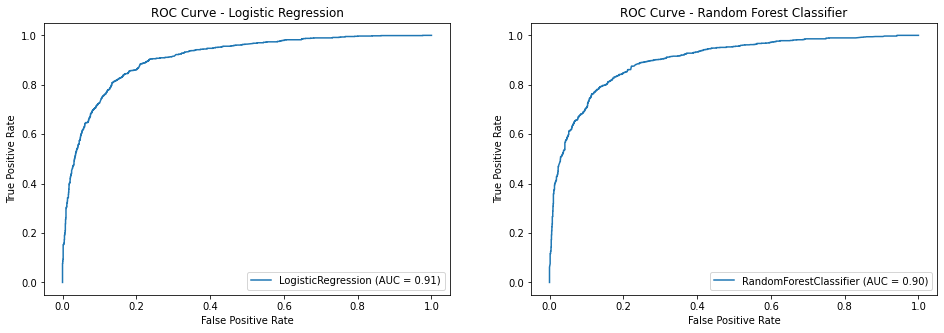

In [75]:
#Plot ROC curve & AUC
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
models = {'Logistic Regression':lr_best, 'Random Forest Classifier':rf_best}

for n,m in models.items():
    plot_roc_curve(m, X_test, y_test, ax=axes[list(models.keys()).index(n)])
    plt.sca(axes[list(models.keys()).index(n)])
    plt.title('ROC Curve - ' + n)

At first glance, the Logistic Regression model appears to perform better. Both models have similar ROC curves, but the Logistic Regression model shows a slightly higher AUC value.

To assess each model's fit, we can compare the AUC score on the training & test sets.

In [76]:
#Compute AUC score on training & test data for the Logistic Regression model
print('Logistic Regression - AUC (training set):', roc_auc_score(y_train, lr_best.predict_proba(X_train)[:,1]))
print('Logistic Regression - AUC (test set):', roc_auc_score(y_test, lr_best.predict_proba(X_test)[:,1]))

Logistic Regression - AUC (training set): 0.9217146374628834
Logistic Regression - AUC (test set): 0.9093719228605089


In [77]:
#Compute AUC score on training & test data for the Random Forest Classifier model
print('Random Forest Classifier - AUC (training set):', roc_auc_score(y_train, rf_best.predict_proba(X_train)[:,1]))
print('Random Forest Classifier - AUC (test set):', roc_auc_score(y_test, rf_best.predict_proba(X_test)[:,1]))

Random Forest Classifier - AUC (training set): 0.9096596003400718
Random Forest Classifier - AUC (test set): 0.9010334243287441


Since the AUC scores on the test sets are just somewhat lower, we may conclude that neither model significantly overfits the data by comparing these AUC scores. We can also confirm that the model with the greatest AUC on the test set, 0.9093, is Logistic Regression.

By contrasting the distribution of the lead scores each of these models assigns for converted and non-converted leads, we can compare how each of these models separates the data in more detail.


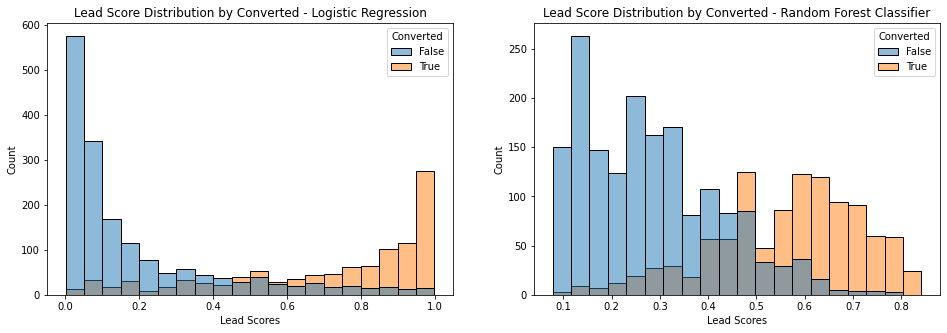

In [78]:
#Plot histogram of lead scores by Converted
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

for n,m in models.items():
    sns.histplot(x=m.predict_proba(X_test)[:,1], hue=y_test, ax=axes[list(models.keys()).index(n)], bins=20)
    plt.sca(axes[list(models.keys()).index(n)])
    plt.title('Lead Score Distribution by Converted - ' + n)
    plt.xlabel('Lead Scores')

The higher AUC score provided by the Logistic Regression model seems to be supported by the aforementioned histograms. In the Logistic Regression histogram, the lead scores appear to be more clearly divided, with less overlap between the scores of converted and non-converted leads.

**As a result, we can choose the Logistic Regression model as our preferred Lead Scoring Model.**

In [79]:
#Assign lr_best as the chosen lead scoring model & get model coefficients + intercept
lead_score_model = lr_best

intercept = lead_score_model.intercept_

coefs = pd.concat([pd.DataFrame(X.columns, columns=['Predictor']),pd.DataFrame(np.transpose(lead_score_model.coef_), columns=['Coefficient'])], axis = 1)

#### Intensifying Conversion Rate

The chief executive officer of X Education said he hoped to see the lead conversion rate rise to about 80%. If we contact leads from highest to lowest lead score, we can use a lift chart to calculate the number of leads that need to be contacted to achieve a conversion rate of 80%.

In [80]:
from scikitplot.metrics import plot_lift_curve

Baseline conversion rate:  38.54 %
Lift equivalent to conversion rate of 80%:  2.08


<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

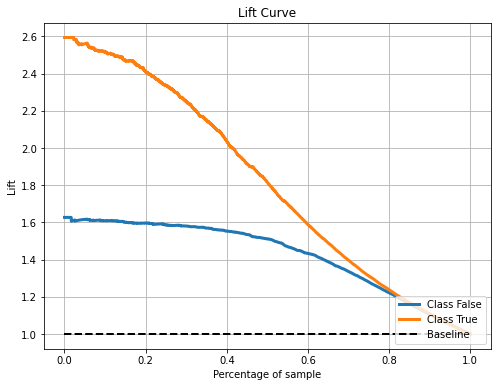

In [81]:
#Plot lift chart
X_scaled = X.copy()
X_scaled[scale_cols] = scaler.transform(X_scaled[scale_cols])

baseline = y.mean()*100
target_lift = 80/baseline
print('Baseline conversion rate: ', round(baseline,2), '%')
print('Lift equivalent to conversion rate of 80%: ', round(target_lift,2))

plot_lift_curve(y,lead_score_model.predict_proba(X_scaled), figsize=(8,6))

The sales team's conversion rate must rise by a factor of 2.08 in order to obtain a conversion rate of 80%. The graph above shows that by contacting the top 35% of leads by lead scores, the sales team may achieve a conversion rate of 80%, presuming that our test set is a fair sample of future leads seen by X Education.

# Conclusion

In conclusion, our created logistic regression model showed to be a more effective lead scoring model. It accurately gives a higher lead score to leads who will convert compared to leads who will not convert in almost 88% of the time. By concentrating on the top 30% of leads according to lead score, the sales force can use this lead scoring approach to raise their conversion rate to 80%.

It would be beneficial to establish a minimum lead score before sales representatives even consider contacting a lead as a suggested next step for X Education. This can be done after the price of paying a sales representative to contact a lead and the value of a lead that is converted have been calculated. Using a profit matrix, the optimal threshold for classification to maximize profit can be identified.